# Rabi experiment

In this tutorial we will combine the techniques explained in the other tutorials and show how to perform a Rabi experiment. For this tutorial we will need one QCM to generate the Rabi pulses and one QRM to perform the readout, although the QCM could be replaced by another QRM if needed.

Ports $\text{O}^{[1-2]}$ of the QCM are used for the driving pulse, while $\text{O}^{[1-2]}$ of the QRM are used for the readout pulse. Finally, ports $\text{I}^{[1-2]}$ are used for the acquisition of the readout tone. In this tutorial it is assumed $\text{O}^{1}$ of the QRM is connected to $\text{I}^{1}$ of the QRM for time of flight calibration.
Furthermore we assume that $\text{O}^{1}$ of the QCM and $\text{O}^{2}$ of the QRM are connected to an external oscilloscope to view the Rabi experiment pattern. The scope can be triggered of marker 1 of the QCM.

As demonstrated in the synchronization tutorial, the SYNQ technology synchronizes the programs in the two modules. If you are using Pulsar modules,
to ensure synchronization between the modules, connect the $\text{REF}^{out}$ of the Pulsar QCM to the 
$\text{REF}^{in}$ of the Pulsar QRM using a coaxial cable, and connect their SYNQ ports using the SYNQ cable.

If you are using a Cluster, then no extra connection needs to be made as the modules are internally connected with SYNQ capability.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable –-py widgetsnbextension
```

## Setup


First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import json
import math

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect_qcm = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select QCM",
)
connect_qrm = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select QRM",
)
connect_cluster = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Cluster",
)

### Pulsar <a id='pulsar_setup'></a>
Select the Pulsar QCM and QRM modules by running the following cell. Skip to the [Cluster](#cluster_setup) if you are using a Cluster.

In [2]:
display(connect_qcm)
display(connect_qrm)

Dropdown(description='Select QCM', options=('pulsar-qcm', 'pulsar-qrm'), value='pulsar-qcm')

Dropdown(description='Select QRM', options=('pulsar-qcm', 'pulsar-qrm'), value='pulsar-qcm')

In [3]:
# Close existing connections to Pulsar
Pulsar.close_all()

# Retrieve device name and IP address and Connect
# QCM
qcm_device_name = connect_qcm.value
qcm_device_number = connect_qcm.options.index(qcm_device_name)
qcm_ip_address = device_list[device_keys[qcm_device_number]]["identity"]["ip"]
qcm = Pulsar(f"{qcm_device_name}", qcm_ip_address)
qcm.reset()  # reset all params
print(f"{qcm_device_name} connected at {qcm_ip_address}")
print(qcm.get_system_state())

# QRM
qrm_device_name = connect_qrm.value
qrm_device_number = connect_qrm.options.index(qrm_device_name)
qrm_ip_address = device_list[device_keys[qrm_device_number]]["identity"]["ip"]
qrm = Pulsar(f"{qrm_device_name}", qrm_ip_address)
qrm.reset()  # reset all params
print(f"{qrm_device_name} connected at {qrm_ip_address}")
print(qrm.get_system_state())

pulsar-qcm connected at 192.168.0.3
Status: OKAY, Flags: NONE, Slot flags: NONE
pulsar-qrm connected at 192.168.0.4
Status: OKAY, Flags: NONE, Slot flags: NONE


In [4]:
# Set reference clock source.
qrm.reference_source("external")

Skip to the next section [(Sequencer Setup)](#seq_setup) if you are not using a cluster. 

#### Cluster <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar section](#pulsar_setup) if you are using a Pulsar.


In [3]:
display(connect_cluster)

Dropdown(description='Select Cluster', options=('cluster-mm',), value='cluster-mm')

In [4]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect_cluster.value
device_number = connect_cluster.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.0.2


We then find all available cluster modules to connect to them individually.

In [5]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

connect_qcm = widgets.Dropdown(
    options=[key for key in available_slots.keys()], description="Select QCM"
)
connect_qrm = widgets.Dropdown(
    options=[key for key in available_slots.keys()], description="Select QRM"
)

cluster-mm connected at 192.168.1.0


Select the QCM and QRM module from the available modules in your Cluster.


In [6]:
print(available_slots)
print()
display(connect_qcm)
display(connect_qrm)

{'module2': 'QCM', 'module4': 'QRM'}


Dropdown(description='Select QCM', options=('module2', 'module4'), value='module2')

Dropdown(description='Select QRM', options=('module2', 'module4'), value='module2')

Finally, we connect to the selected Cluster module. 

In [7]:
# Connect to QCM and QRM
qcm = getattr(
    cluster, connect_qcm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qcm.value]} connected")

qrm = getattr(cluster, connect_qrm.value)
print(f"{available_slots[connect_qrm.value]} connected")
print(cluster.get_system_state())

QCM connected
QCM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


## Sequencer Setup <a id='seq_setup'></a>


Set `sync_en` to synchronize across modules.

In [5]:
# Set sync_en
qrm.sequencer0.sync_en(True)
qcm.sequencer0.sync_en(True)

Configure the `NCO` of both the QRM and QCM to 100 MHz and enable the up- and down-conversion in the sequencers

In [6]:
qrm.sequencer0.nco_freq(100e6)
qrm.sequencer0.mod_en_awg(True)
qrm.sequencer0.demod_en_acq(True)

qcm.sequencer0.nco_freq(100e6)
qcm.sequencer0.mod_en_awg(True)

Configure the outputs of the QRM and QCM such that sequencer0 is the only enabled sequencer and maps to $\text{O}^{[1-2]}$

In [7]:
# Map sequencer of the QCM to specific outputs (but first disable all sequencer connections)
for sequencer in qcm.sequencers:
    for out in range(0, 2):
        sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)
qcm.sequencer0.channel_map_path0_out0_en(True)
qcm.sequencer0.channel_map_path1_out1_en(True)

# Map sequencer of the QRM to specific outputs (but first disable all sequencer connections)
for sequencer in qrm.sequencers:
    for out in range(0, 2):
        sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

## Define waveforms

To readout the systems we define constant pulses `one` and `zero` which will be up converted by the `NCO` to create the appropriate tones for an IQ mixer.
Similarly for driving the qubit, we define a Gaussian pulse, together with a zero pulse of equal length to serve as inputs for an IQ mixer. In this tutorial we do not assume mixers to be connected to the inputs and outputs of the QCM/QRM.

In [8]:
t = np.arange(-80, 81, 1)
sigma = 20
wfs = {
    "zero": {"index": 0, "data": [0.0] * 1024},
    "one": {"index": 1, "data": [1.0] * 1024},
    "gauss": {"index": 2, "data": list(np.exp(-(0.5 * t**2 / sigma**2)))},
    "empty": {"index": 3, "data": list(0.0 * t)},
}

Hence we obtain the following waveforms for readout:

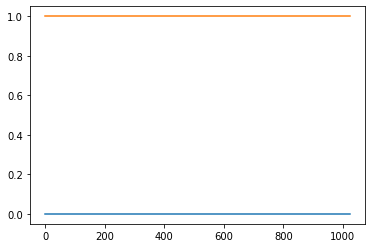

In [9]:
plt.plot(wfs["zero"]["data"])
plt.plot(wfs["one"]["data"])

And for drive:

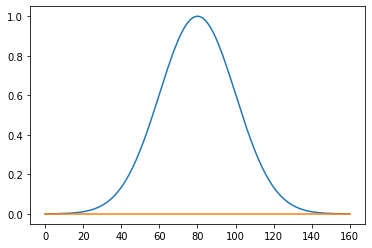

In [10]:
plt.plot(wfs["gauss"]["data"])
plt.plot(wfs["empty"]["data"])

Finally, we define two acquisitions. A single readout to perform the calibration measurements. Secondly we create a `rabi` readout sequence that contains 50 different bins for saving the results, one for each of the different amplitudes used for the drive tone.

In [11]:
num_bins = 50  # Number of amplitudes to be measured
acquisitions = {
    "single": {"num_bins": 1, "index": 0},
    "rabi": {"num_bins": num_bins, "index": 1},
}

## Calibration experiments

### TOF calibration

As a first step, we calibrate the time of flight (tof) for the QRM module. In order to do so, we play a readout pulse and analyze the obtained signal on the oscilloscope to find the travel time of the pulse through the system.

In [12]:
qrm_prog = f"""
play    1, 0, 4     # start readout pulse
acquire 0, 0, 16384 # start the 'single' acquisition sequence and wait for the length of the scope acquisition window
stop
"""

Upload the program, together with the waveforms and acquisitions to the QRM

In [13]:
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Perform the calibration experiment

In [14]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer and acquisition to finish with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)
qrm.store_scope_acquisition(0, "single")
# Print status of sequencer.
print(qrm.get_sequencer_state(0))

Status:
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Analyze the resulting signal on the scope to find the tof

In [15]:
p0 = np.array(
    qrm.get_acquisitions(0)["single"]["acquisition"]["scope"]["path0"]["data"]
)
p1 = np.array(
    qrm.get_acquisitions(0)["single"]["acquisition"]["scope"]["path1"]["data"]
)
tof_measured = (
    np.where(np.abs(p0) > np.max(p0) / 2)[0][0]
    - 1 / qrm.sequencer0.nco_freq() * 1e9 / 8
)

Plot the signal on the scope, around the rising and falling edge of the acquisition signal, as determined by the tof analysis above:

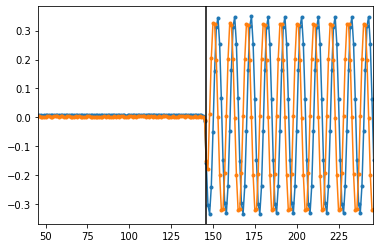

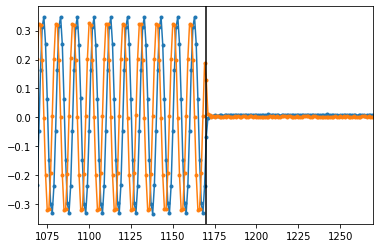

In [16]:
r = qrm.get_acquisitions(0)["single"]["acquisition"]["scope"]
plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(tof_measured, c="k")
plt.xlim(
    tof_measured - 10 / qrm.sequencer0.nco_freq() * 1e9,
    tof_measured + 10 / qrm.sequencer0.nco_freq() * 1e9,
)
plt.show()

plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(1024 + tof_measured, c="k")
plt.xlim(
    1024 + tof_measured - 10 / qrm.sequencer0.nco_freq() * 1e9,
    1024 + tof_measured + 10 / qrm.sequencer0.nco_freq() * 1e9,
)
plt.show()

## Parameters

Set the parameters for the Rabi experiment

In [17]:
# all times must be divisible by 4
reset_time = 200  # reset time for the qubit in microseconds
tof = int(tof_measured / 4) * 4  # time of flight must be divisible by 4
readout_delay = (
    164  # time to delay the readout pulse after the start of the rotation pulse
)

navg = 1000  # number of averages
stepsize = int(65535 / 100)

## Rabi

Normally, a Rabi experiment would be performed by changing the amplitude in the inner loop, and averaging in the outer loop. To make the resulting experiment visible on an oscilloscope however, in this tutorial we swapped these two loops

In [18]:
# QCM sequence program.
qcm_seq_prog = f"""
# Registers used:
# R0 loops over the different awg amplitudes used for the rabi driving pulse
# R2 is used to count the averages needed for a single amplitude
# R3 contains the qubit reset time in microseconds

           move          0, R0                       # start with awg amplitude 0 
           wait_sync     4                           # Synchronize the QRM with the QCM
           
           
ampl_loop: add           R0, {stepsize}, R0          # increase the pulse amplitude by the stepsize
           move          {navg}, R2                  # reset the number of averages and save in the R2 register
           
           # let the qubit relax to its groundstate
navg_loop: move          {reset_time}, R3            # reset the number of microseconds to wait and save in the R3 register
rst_loop:  wait          1000                        # wait 1 microsecond
           loop          R3,@rst_loop                # repeat the 1 microsecond wait as much as needed to let the qubit relax
           
           set_awg_gain  R0, R0                      # Set the new amplitude used for the drive pulse
           set_mrk       1                           # Set marker 1 high for to enable synchronization with external oscilloscope
           wait_sync     4                           # Synchronize with the qrm to signify a measurement is coming
           play          2,3,16384                   # Play waveforms and wait remaining duration of scope acquisition
           
           set_mrk       0                           # Reset marker 1
           upd_param     4
           
           loop          R2,@navg_loop                        # Repeat the experiment to average, until R2 becomes 0
           jlt           R0,{num_bins*stepsize},@ampl_loop    # Repeat the experiment for different pulse amplitudes from 0 to num_bins
           stop                                               # Stop.
           
"""

# QRM sequence program.
qrm_seq_prog = f"""
# Registers used:
# R0 counts which bin to acquire into, a new bin for every new amplitude
# R2 is used to count the averages needed for a single amplitude

           wait_sync     4                           # Synchronize the QRM with the QCM.
           move          0, R0                       # the first acquisition uses bin 0
ampl_loop: move          {navg}, R2                  # reset the amount of averages to be taken to the initial value

navg_loop: wait_sync     {readout_delay}             # wait for the QCM to signal a pulse is coming and wait the readout_delay
           play          1,0,{tof}                   # play readout pulse and wait for the tof
           acquire       1,R0,16384                  # Acquire waveforms and wait remaining duration of scope acquisition.
           
           loop          R2, @navg_loop              # Repeat this measurement for every average
           add           R0,1,R0                     # Increment the bin into which we are measuring
           jmp           @ampl_loop                  # repeat
"""

Upload programs and waveforms to QRM and QCM

In [19]:
# Add QCM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qcm_seq_prog,
}
with open("qcm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Add QRM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": wfs,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_seq_prog,
}
with open("qrm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence to QCM.
qcm.sequencer0.sequence("qcm_sequence.json")

# Upload sequence to QRM.
qrm.sequencer0.sequence("qrm_sequence.json")

Arm and start sequencer0 of both the QCM and QRM. The `wait_sync` command together with the SYNQ technology ensures both modules start simultaneously.

In [21]:
# Arm and start sequencer of the QCM (only sequencer 0).
qcm.arm_sequencer(0)
qcm.start_sequencer(0)

# Print status of sequencer of the QCM.
print("QCM:")
print(qcm.get_sequencer_state(0))
print()

# Arm and start sequencer of the QRM (only sequencer 0).
qrm.arm_sequencer(0)
qrm.start_sequencer(0)

# Print status of sequencer of the QRM.
print("QRM:")
print(qrm.get_sequencer_state(0))
print("QCM:")
print(qcm.get_sequencer_state(0, 1))
qrm.stop_sequencer(
    0
)  # We didn't tell the QRM how many different amplitudes would be measured, so here we tell it to stop.
print("QRM:")
print(qrm.get_sequencer_state(0, 1))

QCM status:
Status: RUNNING, Flags: NONE

QRM status:
Status: RUNNING, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
QCM status:
Status: STOPPED, Flags: NONE
QRM status:
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE


## Stop

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencers.
qcm.stop_sequencer()
qrm.stop_sequencer()

# Print status of sequencers.
print("QCM :")
print(qcm.get_sequencer_state(0))
print()

print("QRM :")
print(qrm.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of instrument parameters.
# print("QCM snapshot:")
# qcm.print_readable_snapshot(update=True)
print()

# print("QRM snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connections.
Pulsar.close_all()
Cluster.close_all()